This notebook provides the code for performing the ancillary dataset comparisons in the JAS paper: Primary Modes of Northern Hemisphere Snowfall Particle Size Distributions

Note that you'll need to pass your own vertical radar dataset/reanalysis data paths.

In [ ]:
### IMPORTS
import numpy as np
import pandas as pd
import warnings
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from datetime import datetime, timedelta
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta

### NOTEBOOK SETTINGS
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 15})

In [ ]:
### DEFINE GLOBALS
FIN_PATH = '...path_to_fin_mrr...'
MQT_PATH = '...path_to_mqt_mrr...'
path = '../data/pip_snow_obs_10_sites_500_subsample.csv'
palette = ['red', '#0f9adb', 'blue', '#8d2c8d', '#e8b400', '#007e58', 'gray', 'black']
sigma = 2

### DEFINE GLOBAL HELPER
def one_decimal_format(x):
    return f'{x:.1f}'
formatter = FuncFormatter(one_decimal_format)

In [2]:
### LOAD MICROPHYSICS DATA
df = pd.read_csv(path)

In [3]:
### RUN THE PCA

# show_pca: see perform_pca.ipynb for additional details
def show_pca(df):
    features = ['n0_log', 'lambda_log', 'Fs', 'Rho_log', 'Sr_log', 'Nt_log']

    for feature in features:
        mean_value = df[feature].mean()
        std_value = df[feature].std()
        df[f"{feature}_norm"] = (df[feature] - mean_value) / std_value
    scaled_data = df.loc[:, ['n0_log_norm', 'lambda_log_norm', 'Fs_norm', 'Rho_log_norm', 'Sr_log_norm', 'Nt_log_norm']].values

    pca = PCA(n_components = 0.95)
    pca.fit(scaled_data)
    principalComponents = pca.transform(scaled_data)
    cols=[]
    for i in range(principalComponents.shape[1]):
        cols.append('eof' + str(i+1))
    principalDf = pd.DataFrame(data = principalComponents, columns = cols)
    df_all = df.reset_index(drop=True)
    principalDf = principalDf.reset_index(drop=True)
    df_combo = pd.concat([df_all, principalDf], axis=1)
    print(pca.explained_variance_ratio_)
    return df_combo

df_combo = show_pca(df, 'inferno')


[0.54687505 0.23733483 0.15768706 0.03152706]
PCA complete


In [4]:
### ASSIGN PC GROUPS
df_combo['eof1_dir'] = df_combo['eof1'].apply(lambda x: 'pos' if x > 0 else 'neg')
df_combo['eof2_dir'] = df_combo['eof2'].apply(lambda x: 'pos' if x > 0 else 'neg')
df_combo['eof3_dir'] = df_combo['eof3'].apply(lambda x: 'pos' if x > 0 else 'neg')
new_df = df_combo[['n0_log', 'lambda_log', 'Rho_log', 'Nt_log', 'Sr_log', 'Fs', 'Dm', 'eof1', 'eof2', 'eof3']]

groups = {
    1: [
        [[-np.inf, -sigma], [-np.inf, np.inf], [-sigma, sigma]]
    ],
    2: [
        [[-sigma, sigma], [sigma, np.inf], [-np.inf, np.inf]]
    ],
    3: [
        [[sigma, np.inf], [-np.inf, np.inf], [-sigma, sigma]]
    ],
    4: [
        [[-sigma, sigma], [-np.inf, -sigma], [-np.inf, np.inf]]
    ],
    5: [
        [[-np.inf, np.inf], [-sigma, sigma], [sigma, np.inf]]
    ],
    6: [
        [[-np.inf, np.inf], [-sigma, sigma], [-np.inf, -sigma]]
    ]
}

def assign_group(row):
    for group, conditions in groups.items():
        for condition in conditions:
            range1, range2, range3 = condition
            if range1[0] <= row['eof1'] <= range1[1] and range2[0] <= row['eof2'] <= range2[1] and range3[0] <= row['eof3'] <= range3[1]:
                return group
    return 7

# Below are custom helper functions for parsing other surface MET/Radar datasets for later comparisons
def find_indices_in_range(data_list, lower_bound, upper_bound):
    indices = [i for i, value in enumerate(data_list) if lower_bound <= value <= upper_bound]
    return indices

def date_to_seconds(date_str):
    date_obj = datetime.strptime(date_str, '%Y%m%d')
    epoch = datetime(1970, 1, 1)
    return (date_obj - epoch).total_seconds()

def read_data(file_path, start_seconds, end_seconds):
    dataset = xr.open_dataset(file_path)

    utc_time_seconds = dataset['UTC Time'].values / np.timedelta64(1, 's')
    utc_time_seconds_list = utc_time_seconds.tolist()

    indices = find_indices_in_range(utc_time_seconds_list, start_seconds, end_seconds)
    rh_out = dataset['RH Out'].isel(time=indices)
    temp_out = dataset['Temp Out'].isel(time=indices) + 273.15
    pressure = dataset['Pressure'].isel(time=indices)

    return rh_out, temp_out, pressure

df_combo['group'] = df_combo.apply(assign_group, axis=1)
df_combo['time'] = pd.to_datetime(df_combo['time'])
df_combo = df_combo[df_combo['n0_log'] >= 0]
df_combo = df_combo[df_combo['Fs'] >= 0]
df_combo = df_combo[df_combo['Fs'] <= 3]
df_combo = df_combo[df_combo['Rho_log'] >= -2]
df_combo = df_combo[df_combo['lambda_log'] <= 0.5]


Working on path MRR_NWS_MQT_20181202_snow.nc


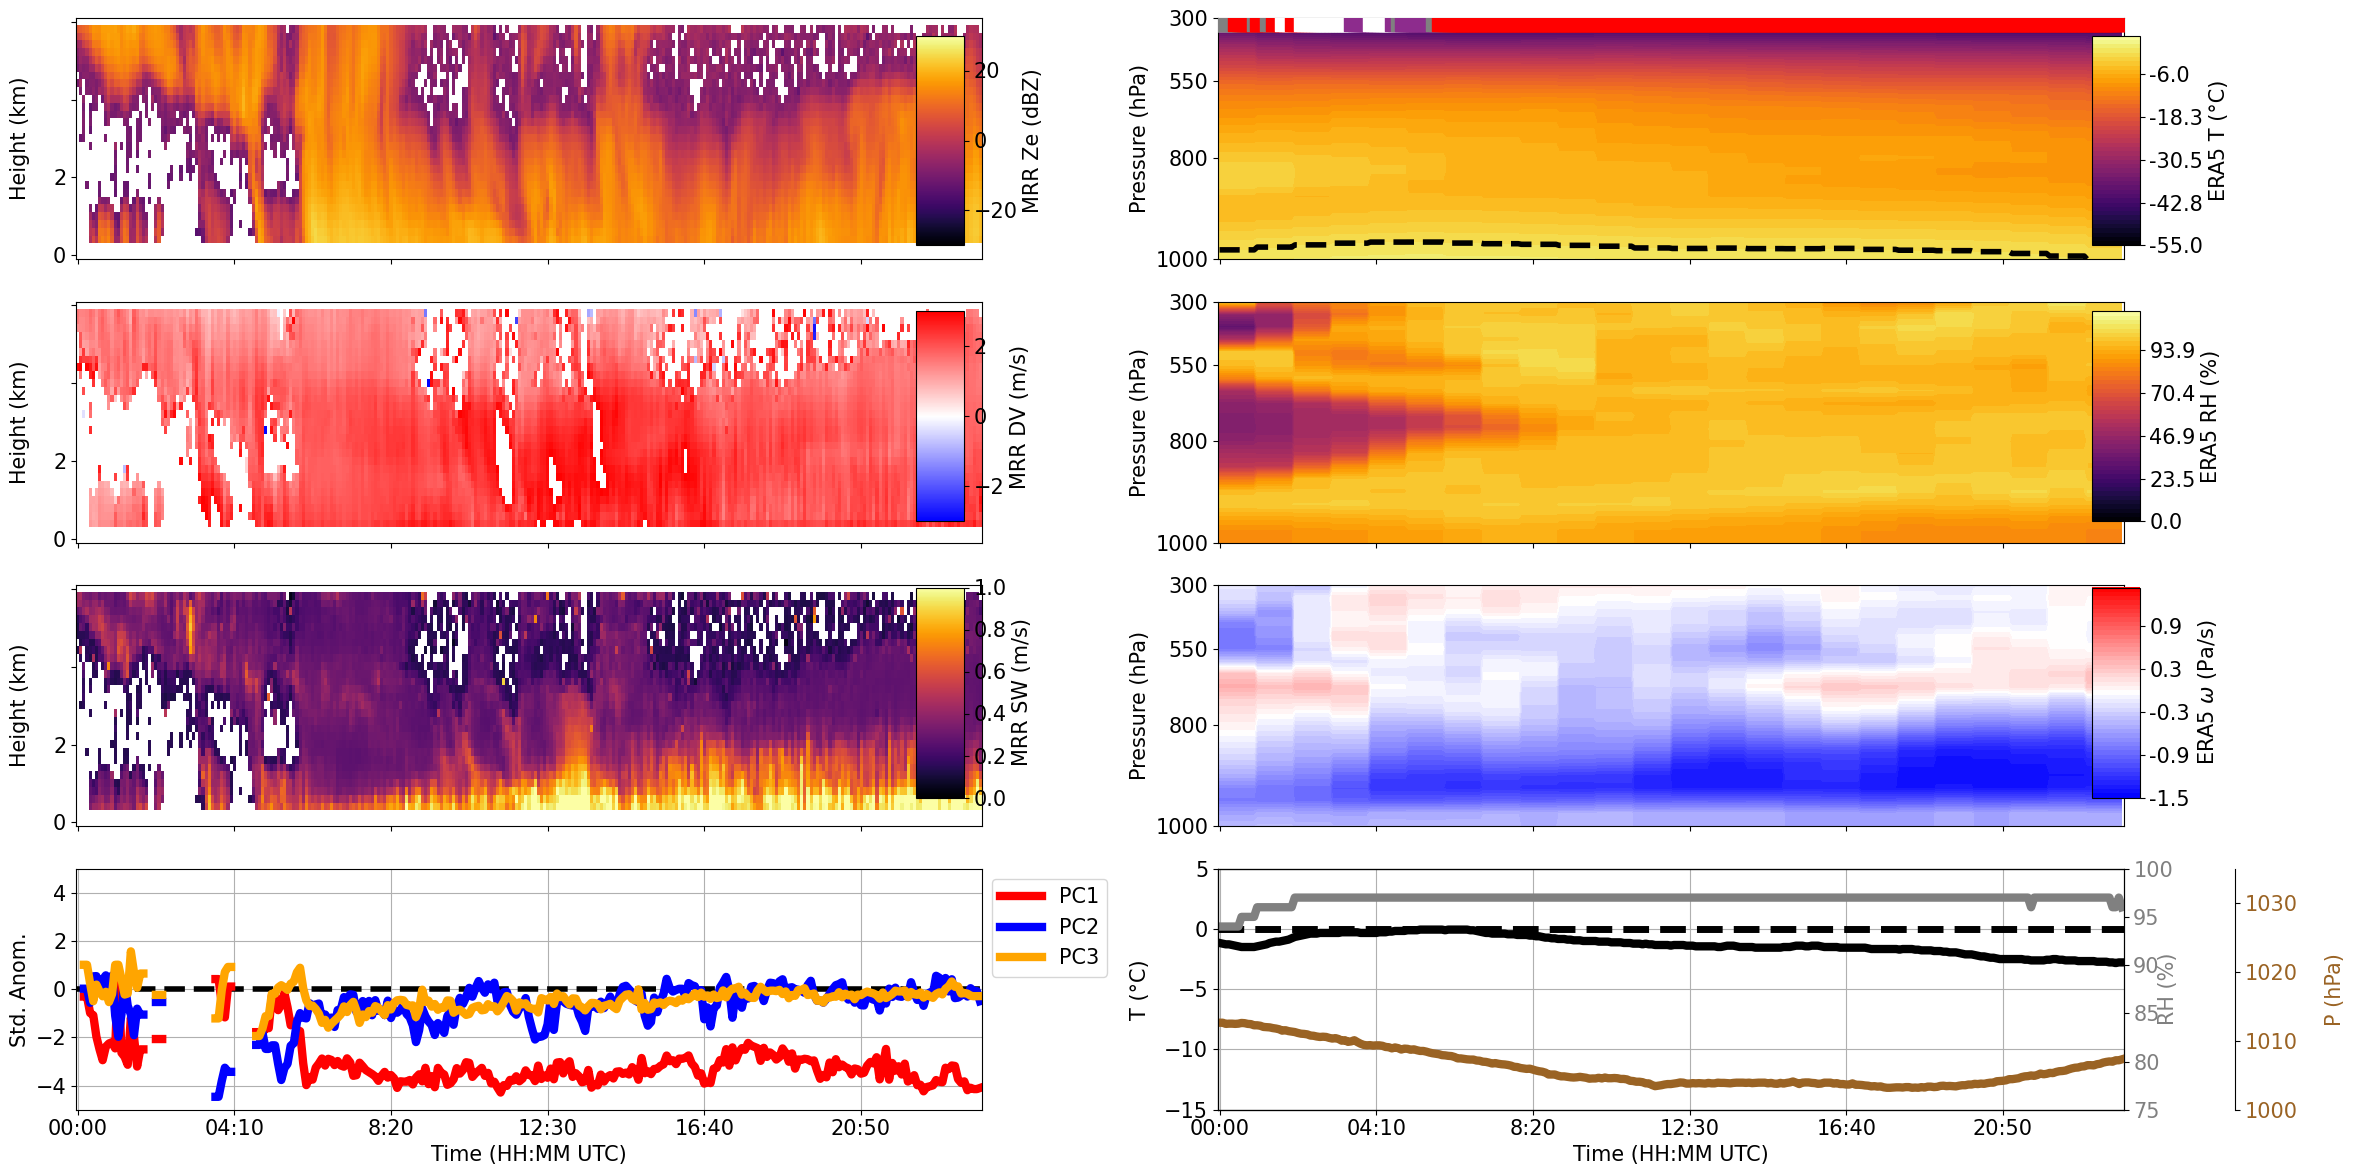

Working on path MRR_NWS_MQT_20181120_snow.nc


<Figure size 640x480 with 0 Axes>

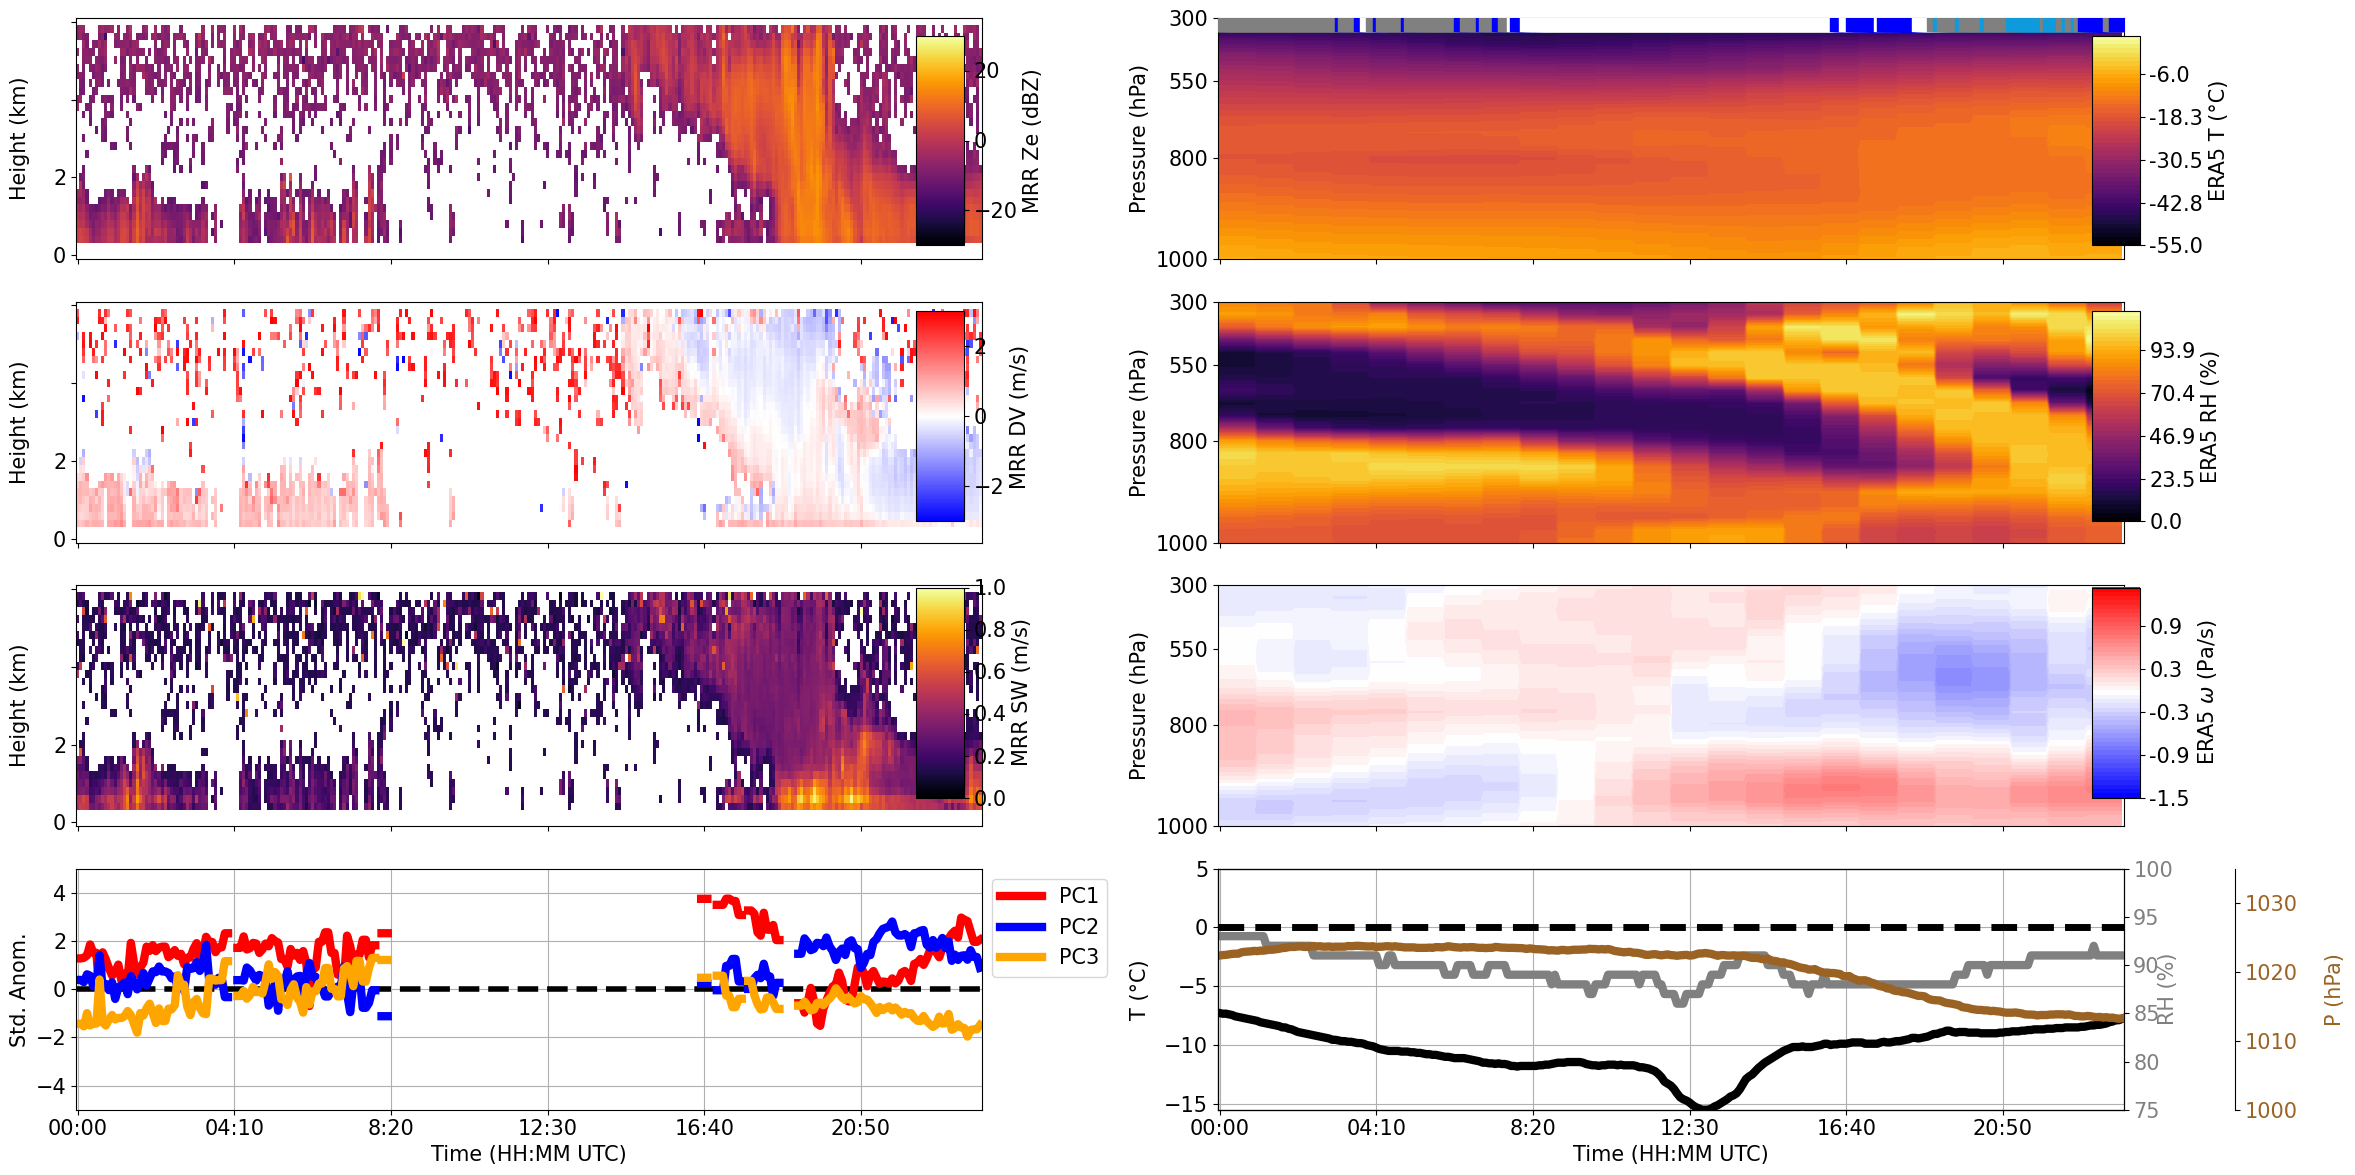

Working on path MRR_NWS_MQT_20190110_snow.nc


<Figure size 640x480 with 0 Axes>

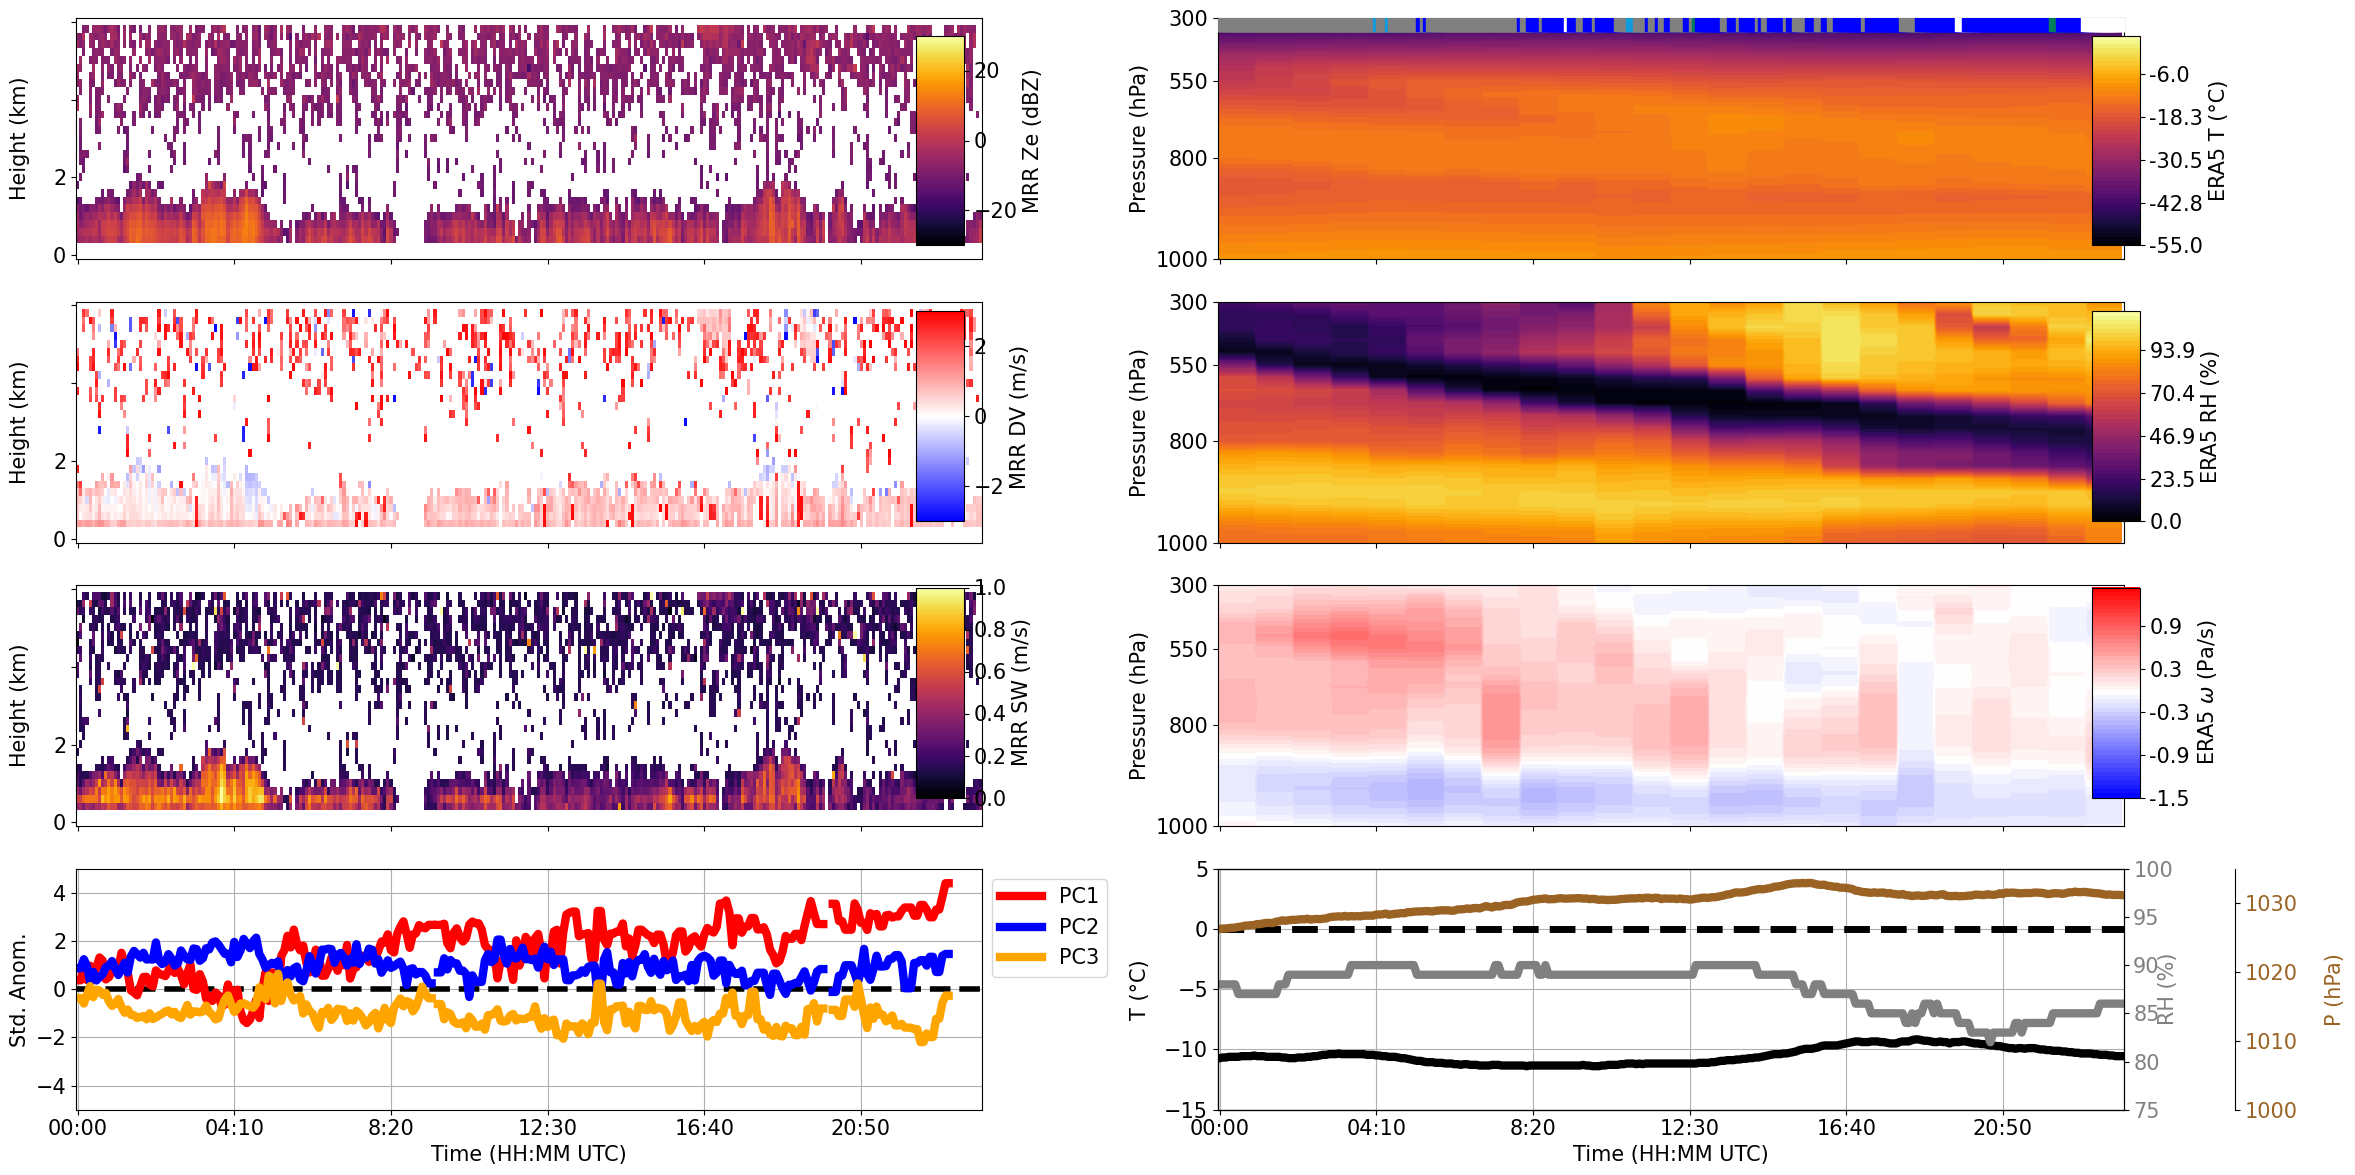

Working on path MRR_NWS_MQT_20180123_snow.nc


<Figure size 640x480 with 0 Axes>

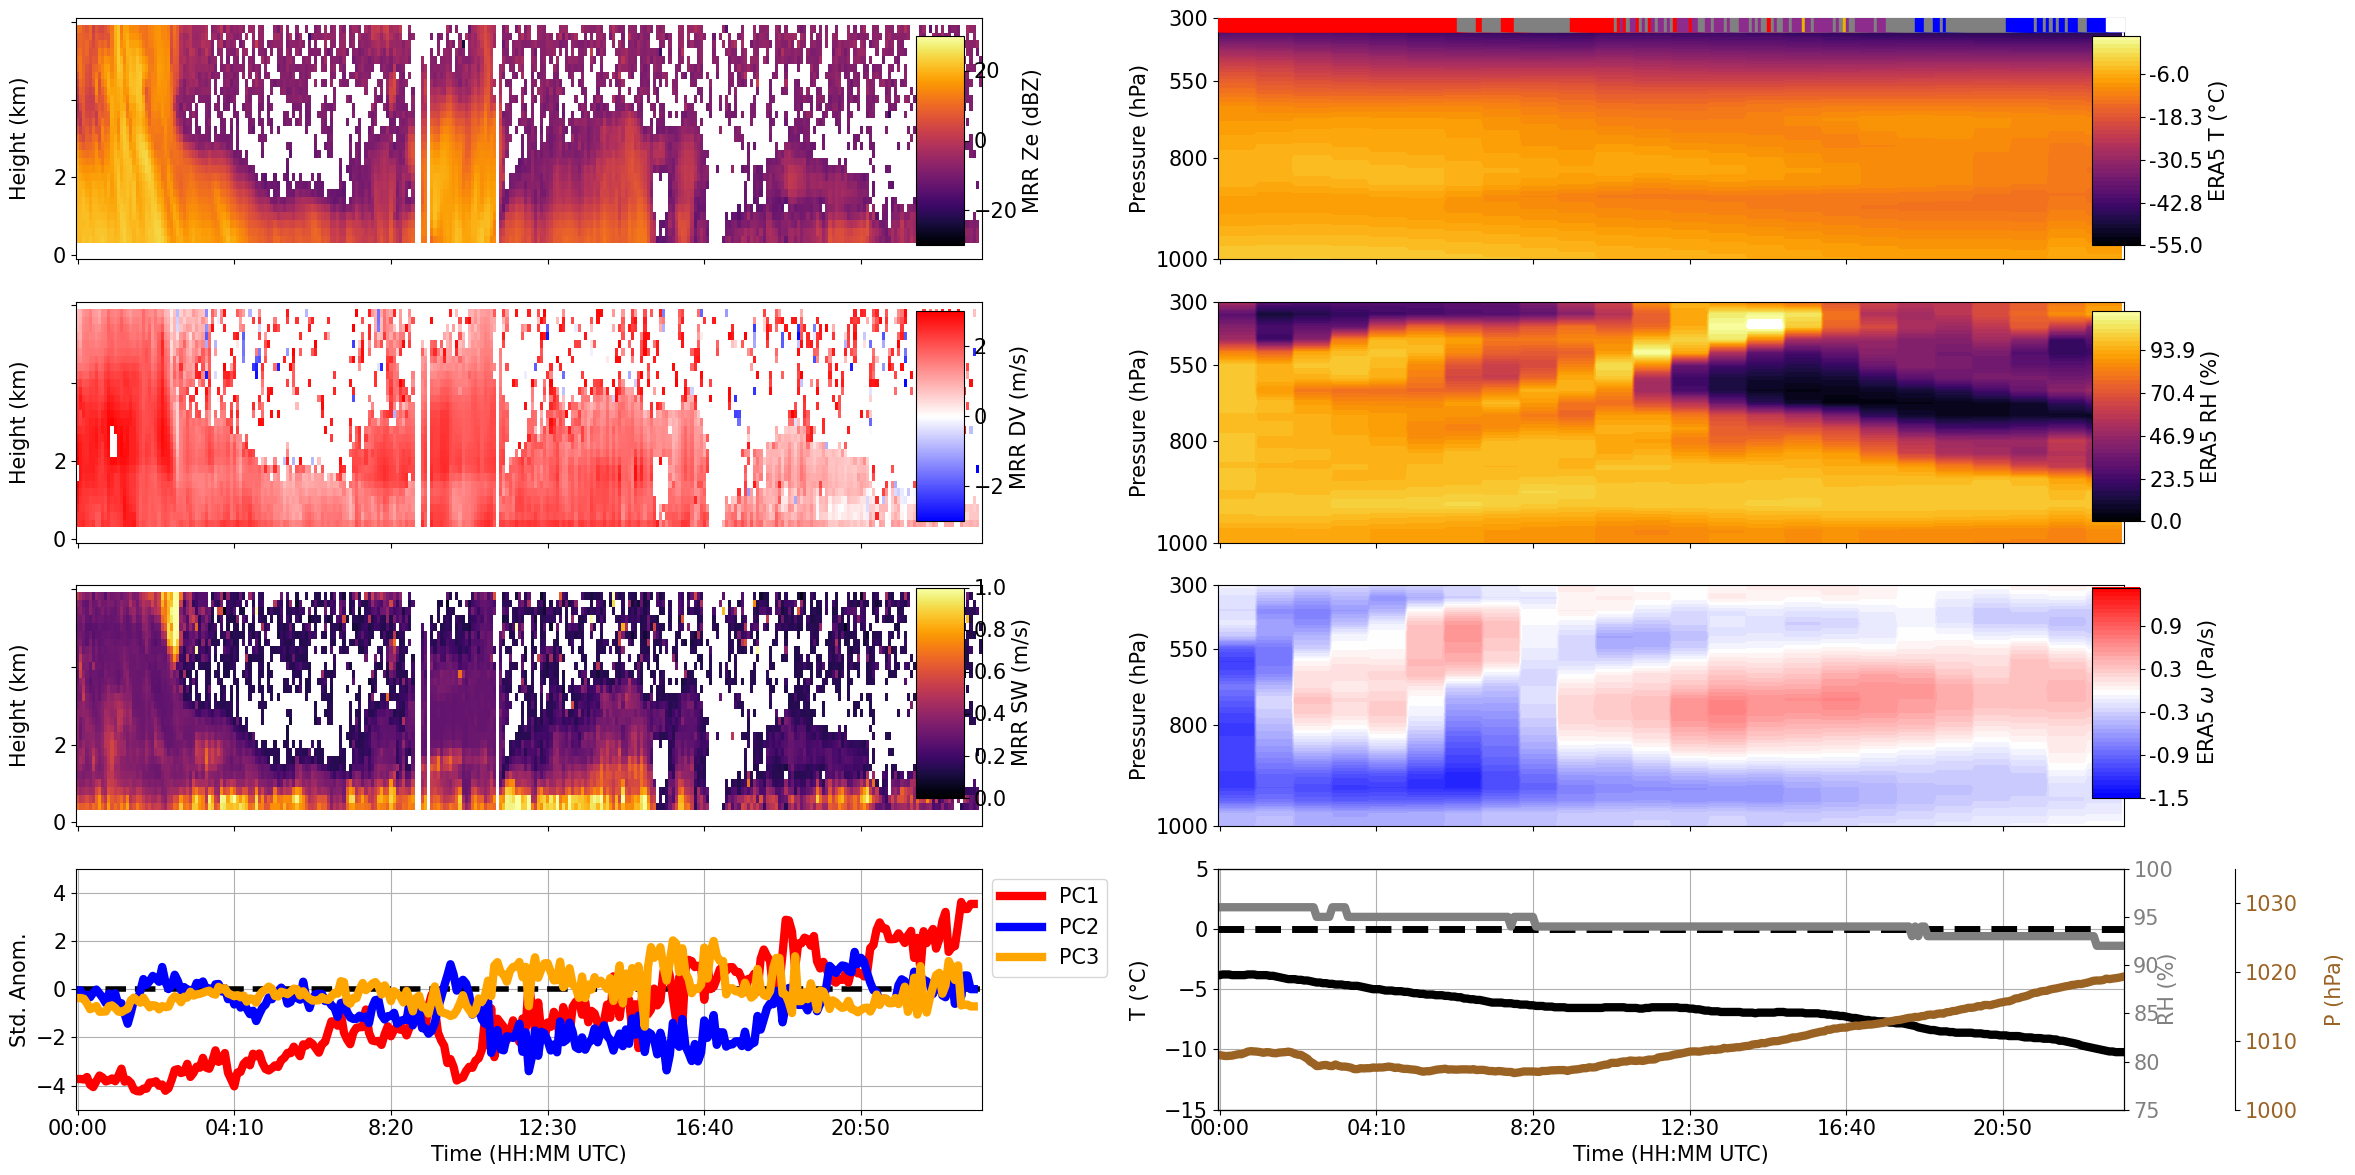

Working on path MRR_NWS_MQT_20190130_snow.nc


<Figure size 640x480 with 0 Axes>

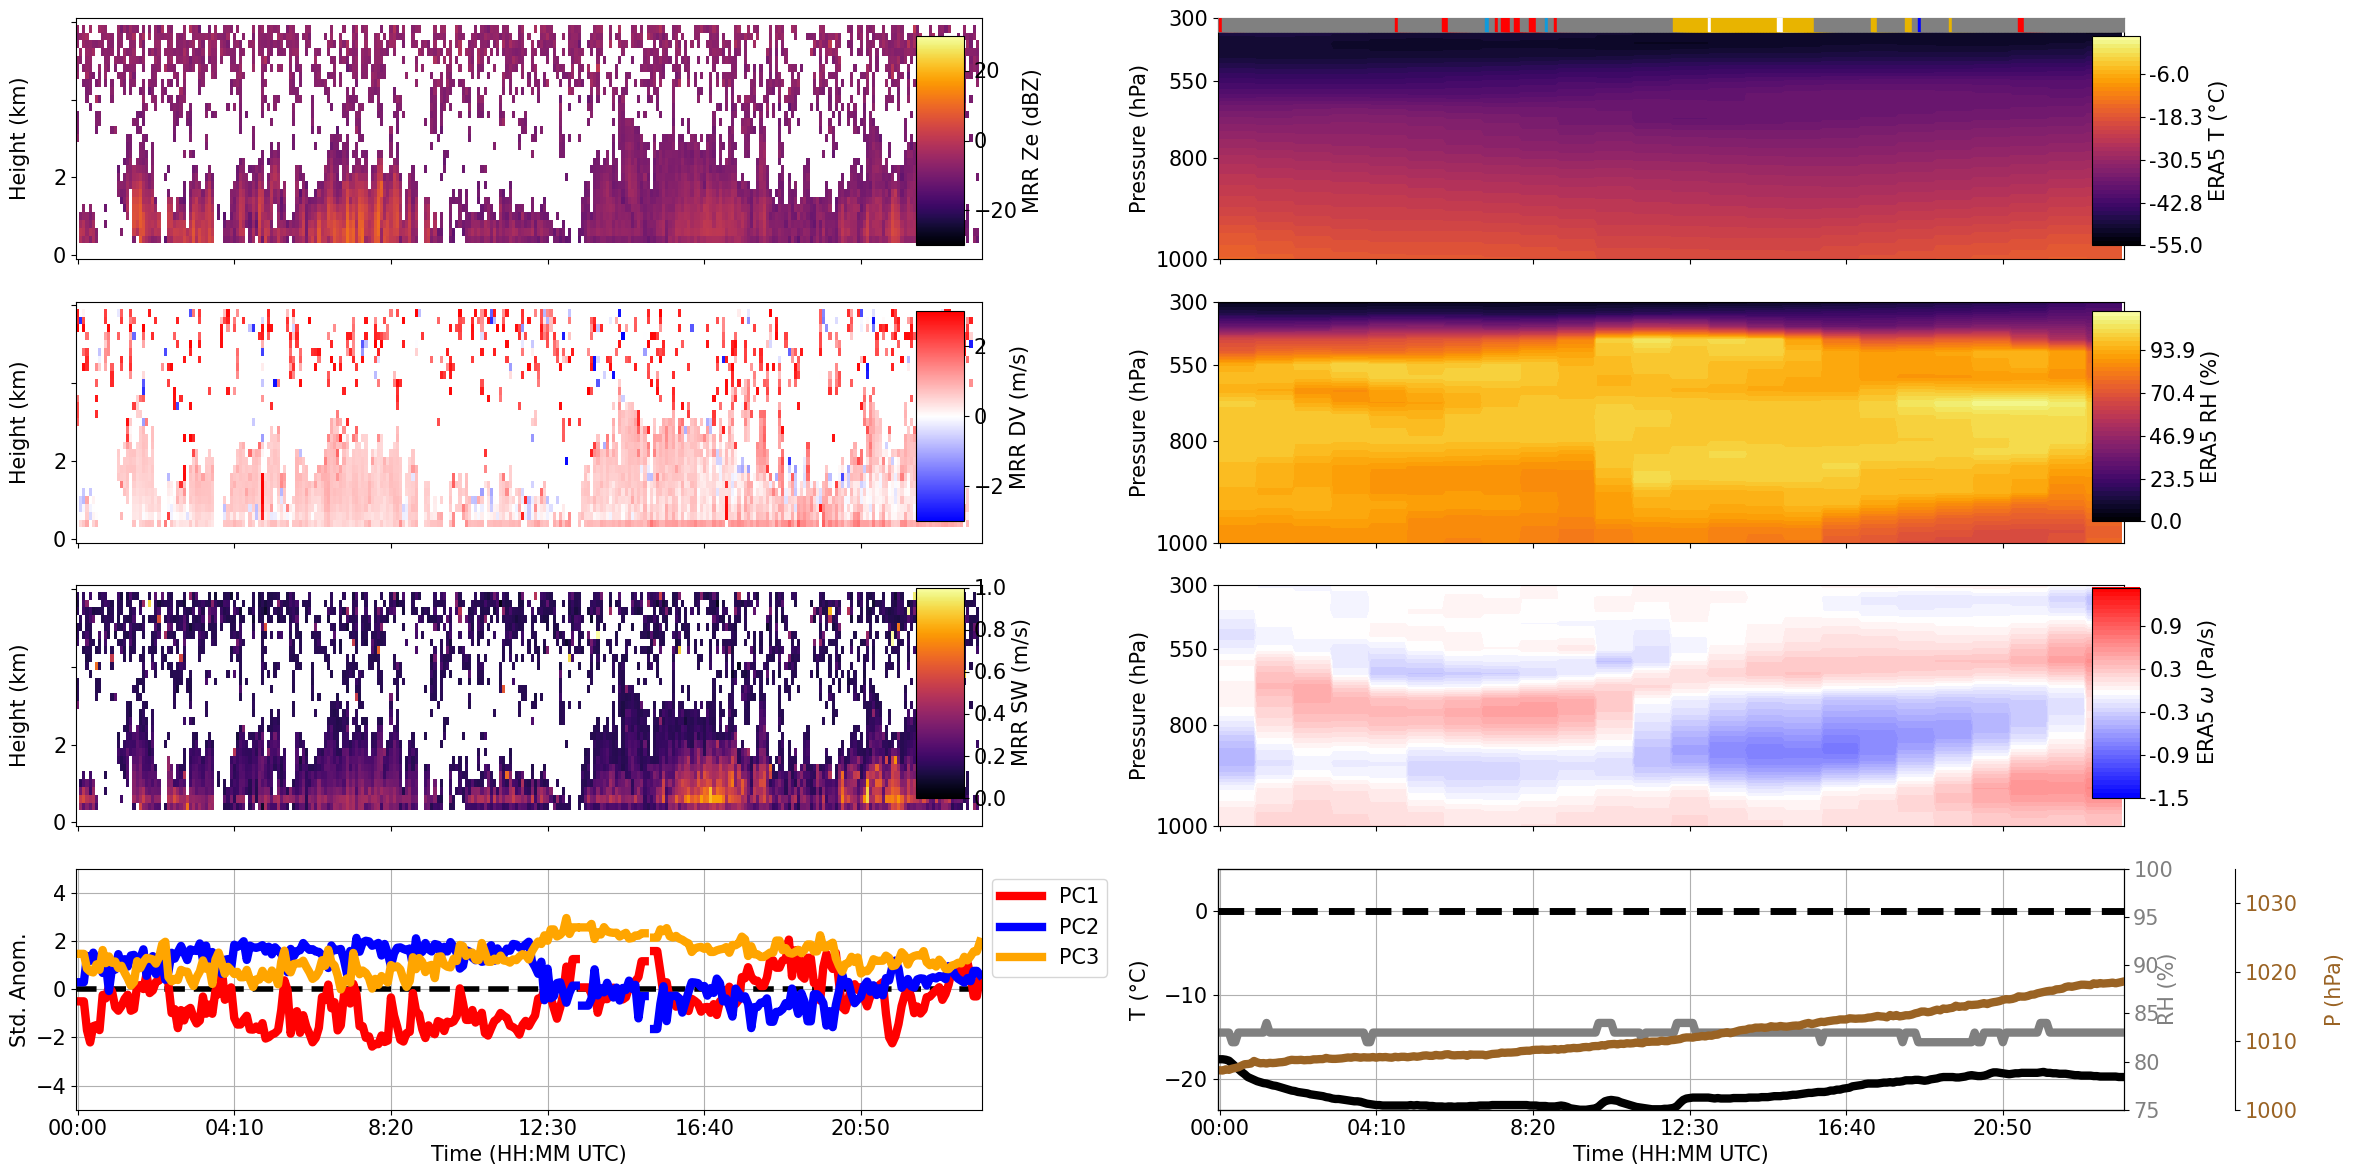

Working on path MRR_NWS_MQT_20160305_snow.nc


<Figure size 640x480 with 0 Axes>

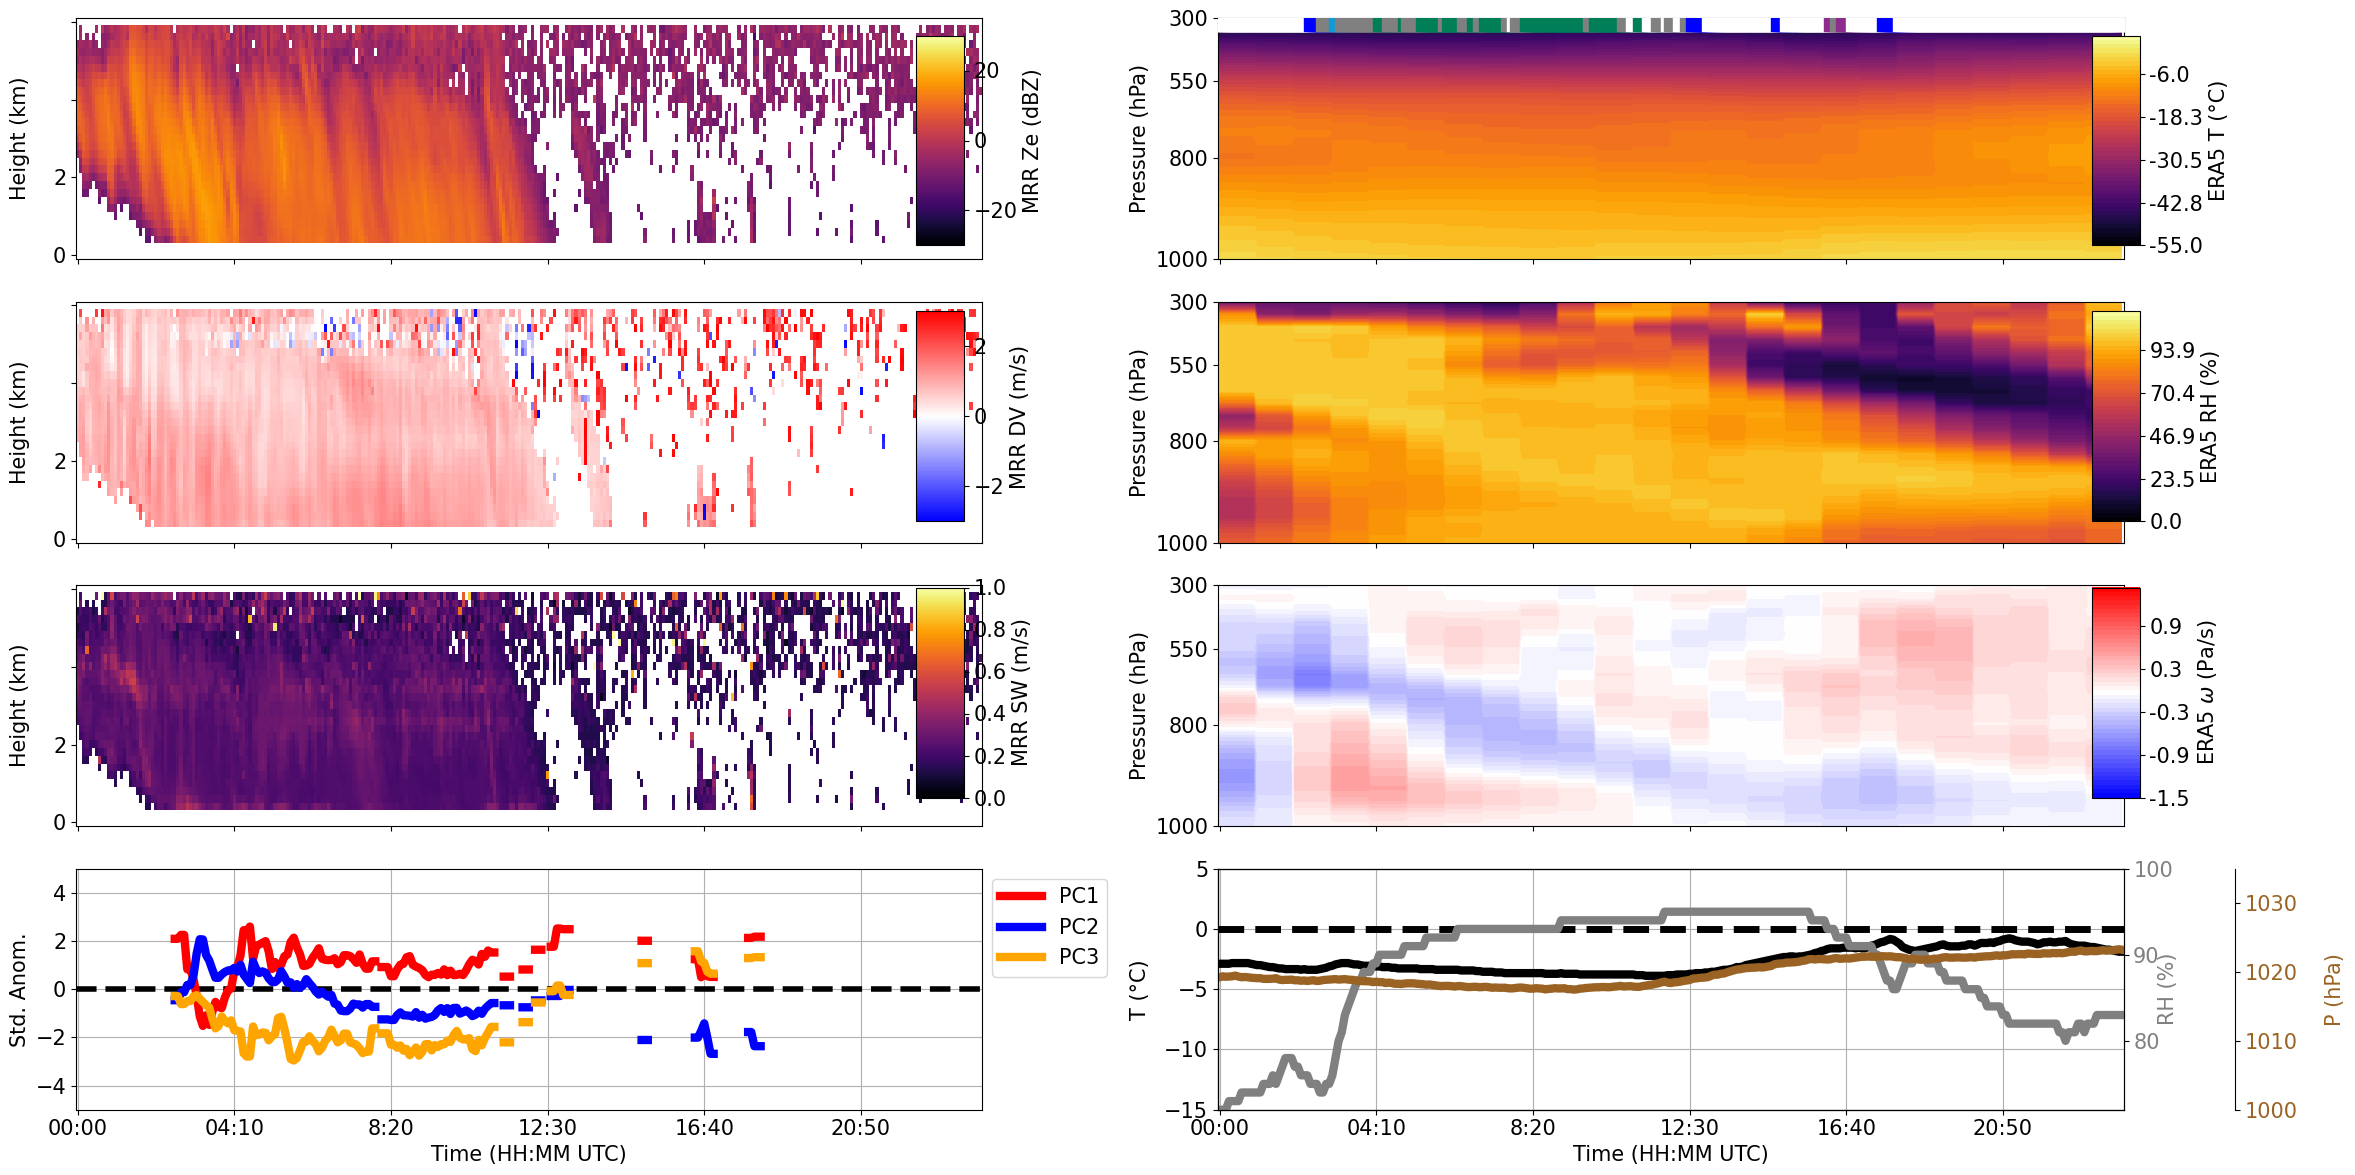

<Figure size 640x480 with 0 Axes>

In [8]:
### MULTI-PLOT ANCILLARY COMPARISONS

# plot_mmr_met_examples_mqt: Helper for plotting various days of interest at MQT, with data from PIP, MRR, ERA5, MET
def plot_mmr_met_examples_mqt():
    global palette
    df = df_combo[df_combo['site'] == 'MQT']

    paths = [
        'MRR_NWS_MQT_20181202_snow.nc',
        'MRR_NWS_MQT_20181120_snow.nc',
        'MRR_NWS_MQT_20190110_snow.nc',
        'MRR_NWS_MQT_20180123_snow.nc',
        'MRR_NWS_MQT_20190130_snow.nc',
        'MRR_NWS_MQT_20160305_snow.nc',
        ]

    era5_indices = [1008, 936, 1200, 672, 1272, 168]

    for j, path in enumerate(paths):
        print("Working on path", path)

        def reshape_to_5min_intervals(nc_file_path):
            nc_data = xr.open_dataset(MQT_PATH + nc_file_path)
            nc_data = nc_data[['time', 'Ze', 'W', 'spectralWidth']]
            nc_resampled = nc_data.resample(time='5Min').mean()
            return nc_resampled

        resampled_nc_data = reshape_to_5min_intervals(path)

        # Lists to store the extracted values and dates
        eof1_list = []
        eof2_list = []
        eof3_list = []
        group_list = []
        date_list = []

        n0_list = []
        lambda_list = []
        color_list = []

        ambig_n0_list = []
        ambig_lambda_list = []
        ambig_color_list = []
        
        # Time matching
        count = 0
        for nc_time in resampled_nc_data['time'].values:
            nc_datetime = pd.to_datetime(str(nc_time))
            closest_row = df.iloc[(df['time'] - nc_datetime).abs().argsort()[:1]]
            date_list.append(nc_datetime)

            # Find the nearest time in the DataFrame, within 5 minutes
            closest_row = df.iloc[(df['time'] - nc_datetime).abs().argsort()[:1]]

            if not closest_row.empty:
                closest_time = closest_row['time'].values[0]
                time_difference = abs(nc_datetime - pd.to_datetime(closest_time))

                # Check if the closest time is within 5 minutes
                if time_difference <= timedelta(minutes=5):
                    eof1_list.append(closest_row['eof1'].values[0])
                    eof2_list.append(closest_row['eof2'].values[0])
                    eof3_list.append(closest_row['eof3'].values[0])
                    group_list.append(closest_row['group'].values[0])

                    if closest_row['group'].values[0]-1 == 6:
                        ambig_n0_list.append(closest_row['n0'].values[0])
                        ambig_lambda_list.append(closest_row['lambda'].values[0])
                        ambig_color_list.append(palette[closest_row['group'].values[0]-1])
                    else:
                        n0_list.append(closest_row['n0'].values[0])
                        lambda_list.append(closest_row['lambda'].values[0])
                        color_list.append(palette[closest_row['group'].values[0]-1])

                else:
                    # Add NaNs if the nearest time is more than 5 minutes away
                    eof1_list.append(np.nan)
                    eof2_list.append(np.nan)
                    eof3_list.append(np.nan)
                    group_list.append(np.nan)
            else:
                # Add NaNs if no closest time found
                eof1_list.append(np.nan)
                eof2_list.append(np.nan)
                eof3_list.append(np.nan)
                group_list.append(np.nan)


        # Extract date from filename
        date_str = path.split('_')[3]
        start_seconds = date_to_seconds(date_str)
        end_seconds = start_seconds + 86400 

        rh_out, temp_out, pressure = read_data('/Users/fraserking/Development/pca/data/2013-2020_MQT.nc', start_seconds, end_seconds)

        ##### SUPERFIGURE Start

        zh_data = resampled_nc_data['Ze'][:, :].T
        dv_data = resampled_nc_data['W'][:, :].T
        sw_data = resampled_nc_data['spectralWidth'][:, :].T
        dv_data = np.where(dv_data < -3, np.nan, dv_data)
        dv_data = np.where(dv_data > 3, np.nan, dv_data)
        x_values = range(len(eof1_list))

        fig, axes = plt.subplots(4, 2, figsize=(24, 12), sharex=True)
        flat_axes = axes.flatten()
        palette = ['red', '#0f9adb', 'blue', '#8d2c8d', '#e8b400', '#007e58', 'gray', 'black']
        color_map = {i + 1: palette[i] for i in range(7)}
        color_map[np.nan] = 'white'

        ax1 = flat_axes[0]
        im = ax1.imshow(zh_data, aspect='auto', cmap='inferno', origin='lower', vmin=-30, vmax=30)
        ax1.set_yticklabels([0, 0, 2])
        ax1.set_ylabel("Height (km)")
        cbar_ax = fig.add_axes([0.395, 0.785, 0.02, 0.175])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label('MRR Ze (dBZ)')

        # for x, group in zip(x_values, group_list):
        #     if group == 7:
        #         ax1.scatter(x, 30, color=color_map[group], marker='s', s=200)
        #     else: 
        #         ax1.scatter(x, 30, color=color_map[group], marker='s', s=200, zorder=1001) 
        
        ax11 = flat_axes[2]
        im = ax11.imshow(dv_data, aspect='auto', cmap='bwr', origin='lower', vmin=-3, vmax=3)  
        ax11.set_yticklabels([0, 0, 2])
        ax11.set_ylabel("Height (km)")
        cbar_ax = fig.add_axes([0.395, 0.555, 0.02, 0.175]) 
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label('MRR DV (m/s)')

        ax11 = flat_axes[4]
        im = ax11.imshow(sw_data, aspect='auto', cmap='inferno', origin='lower', vmin=0, vmax=1)
        ax11.set_yticklabels([0, 0, 2])
        ax11.set_ylabel("Height (km)")
        cbar_ax = fig.add_axes([0.395, 0.325, 0.02, 0.175]) 
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label('MRR SW (m/s)')

        ax2 = flat_axes[6]
        ax2.grid()
        ax2.axhline(0, color='black', linewidth=4, linestyle='--')
        ax2.plot(x_values, eof1_list, color='red', linewidth=6, label='PC1')
        ax2.plot(x_values, eof2_list, color='blue', linewidth=6, label='PC2')
        ax2.plot(x_values, eof3_list, color='orange', linewidth=6, label='PC3')
        ax2.set_ylim((-5, 5))
        ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax2.set_ylabel('Std. Anom.')

        ## ERA5
        ds_era5 = xr.open_dataset('/Users/fraserking/Development/pca/data/era5_mqt/era5.nc')
        data_t = ds_era5.t[era5_indices[j]:era5_indices[j]+24, :, 2, 2]
        data_q = ds_era5.r[era5_indices[j]:era5_indices[j]+24, :, 2, 2]
        data_w = ds_era5.w[era5_indices[j]:era5_indices[j]+24, :, 2, 2]
        data_t = data_t.values - 273.15
        data_t_minute = np.repeat(data_t, 12, axis=0)
        data_q_minute = np.repeat(data_q, 12, axis=0)
        data_w_minute = np.repeat(data_w, 12, axis=0)
        time_units_minute = np.linspace(0, 288, 288)  # Time units in minutes
        levels = np.linspace(0, 19, 20) 
        Time, Level = np.meshgrid(time_units_minute, levels, indexing='ij')

        ax3 = flat_axes[1]
        contour = ax3.contourf(Time, Level, data_t_minute, cmap='inferno', levels=np.linspace(-55, 5), aspect='auto')
        zero_degree_contour = ax3.contour(Time, Level, data_t_minute, levels=[0], colors='black', linewidths=4, linestyles='dashed')

        ax3.invert_yaxis()
        custom_pressure_levels = ['300', '550', '800', '1000']
        custom_pressure_indices = [0, 5, 11, 19]
        ax3.set_yticks(custom_pressure_indices)
        ax3.set_yticklabels(custom_pressure_levels)
        cbar_ax = fig.add_axes([0.885, 0.785, 0.02, 0.175]) 
        cbar = fig.colorbar(contour, cax=cbar_ax)
        ticks = cbar.get_ticks()
        new_ticks = ticks[::2]
        cbar.set_ticks(new_ticks)
        cbar.ax.yaxis.set_major_formatter(formatter)
        cbar.set_label('ERA5 T (°C)')
        ax3.set_ylabel('Pressure (hPa)')
        ax2.set_xticklabels(['', '00:00', '04:10', '8:20', '12:30', '16:40', '20:50'])
        ax2.set_xlabel('Time (HH:MM UTC)')

        # for x, group in zip(x_values, group_list):
        #     if group == 7:
        #         ax3.scatter(x, 0, color=color_map[group], marker='s', s=350) 
        #     else: 
        #         ax3.scatter(x, 0, color=color_map[group], marker='s', s=350, zorder=1001)

        ax5 = flat_axes[3]
        contour = ax5.contourf(Time, Level, data_q_minute, cmap='inferno', levels=np.linspace(0,115), aspect='auto')
        ax5.invert_yaxis()
        custom_pressure_levels = ['300', '550', '800', '1000']
        custom_pressure_indices = [0, 5, 11, 19]
        ax5.set_yticks(custom_pressure_indices)
        ax5.set_yticklabels(custom_pressure_levels)
        cbar_ax = fig.add_axes([0.885, 0.555, 0.02, 0.175])
        cbar = fig.colorbar(contour, cax=cbar_ax)
        ticks = cbar.get_ticks()
        new_ticks = ticks[::2]
        cbar.set_ticks(new_ticks)
        cbar.ax.yaxis.set_major_formatter(formatter)
        cbar.set_label('ERA5 RH (%)')
        ax5.set_ylabel('Pressure (hPa)')

        ax6 = flat_axes[5]
        contour = ax6.contourf(Time, Level, data_w_minute, cmap='bwr', levels=np.linspace(-1.5,1.5), aspect='auto')
        ax6.invert_yaxis()
        custom_pressure_levels = ['300', '550', '800', '1000']
        custom_pressure_indices = [0, 5, 11, 19]
        ax6.set_yticks(custom_pressure_indices)
        ax6.set_yticklabels(custom_pressure_levels)
        cbar_ax = fig.add_axes([0.885, 0.325, 0.02, 0.175])
        cbar = fig.colorbar(contour, cax=cbar_ax)
        ticks = cbar.get_ticks()
        new_ticks = ticks[::2]
        cbar.set_ticks(new_ticks)
        cbar.ax.yaxis.set_major_formatter(formatter)
        cbar.set_label('ERA5 $\omega$ (Pa/s)')
        ax6.set_ylabel('Pressure (hPa)')


        ax4 = flat_axes[7]
        ax4.grid()
        ax4.plot(np.arange(len(temp_out)), temp_out-273.15, color='black', linewidth=6, label='temperature')
        ax4.set_ylabel('T (°C)', color='black')
        ax4.tick_params(axis='y', labelcolor='black')
        ax4.axhline(0, color='black', linestyle='--', linewidth=5)
        ax4.set_ylim((np.min([-15, np.min(temp_out-273.15)]), 5))
        ax4.set_xlabel('Time (5 minute Intervals since midnight)')

        ax5 = ax4.twinx()  
        ax5.plot(np.arange(len(rh_out)), rh_out, color='gray', linewidth=6, label='Relative Humidity')
        ax5.set_ylabel('RH (%)', color='gray', labelpad=-100)
        ax5.set_ylim((np.min([75, np.min(rh_out)]), 100))
        ax5.tick_params(axis='y', labelcolor='gray')

        ax6 = ax4.twinx()
        ax6.spines["right"].set_position(("outward", 80)) 
        ax6.plot(np.arange(len(pressure)), pressure, color='#9A6324', linewidth=6, label='pressure')
        ax6.set_ylabel('P (hPa)', color='#9A6324', labelpad=20)
        ax6.set_ylim((np.min([1000, np.min(pressure)]), 1035))
        ax6.tick_params(axis='y', labelcolor='#9A6324')

        flat_axes[7].set_xticklabels(['', '00:00', '04:10', '8:20', '12:30', '16:40', '20:50'])
        flat_axes[7].set_xlabel('Time (HH:MM UTC)')

        fig.align_labels()
        plt.tight_layout()
        plt.show()
        plt.clf()

# plot_mmr_met_examples_mqt()

Reflectivity Column 0 9.111362104227636
Reflectivity Column 1 0.7462991376327441
Reflectivity Column 2 -5.205391064589274
Reflectivity Column 3 2.1702439712592607
Reflectivity Column 4 -4.006229134734994
Reflectivity Column 5 3.7601370117672572
DV Column 0 1.2088458818152996
DV Column 1 0.5599560140153844
DV Column 2 0.6456378057395226
DV Column 3 1.298869595934007
DV Column 4 0.7797521357649992
DV Column 5 0.9705520788274504
SW Column 0 0.48258838456396336
SW Column 1 0.37441937415384624
SW Column 2 0.3334089862651447
SW Column 3 0.4997223248007468
SW Column 4 0.3996297129353229
SW Column 5 0.31239023047058806
T Column 0 -41.71754967146771
mean T 270.0781754229849
T Column 1 -42.661913627846126
mean T 261.60291411764706
T Column 2 -43.57338944168604
mean T 264.61464635514017
T Column 3 -41.072830043823295
mean T 272.04488064958826
T Column 4 -42.553864617097766
mean T 267.59672513064135
T Column 5 -43.02113931058827
mean T 267.3019766756032
RH Column 0 88.43511457677032
RH Column 1 74

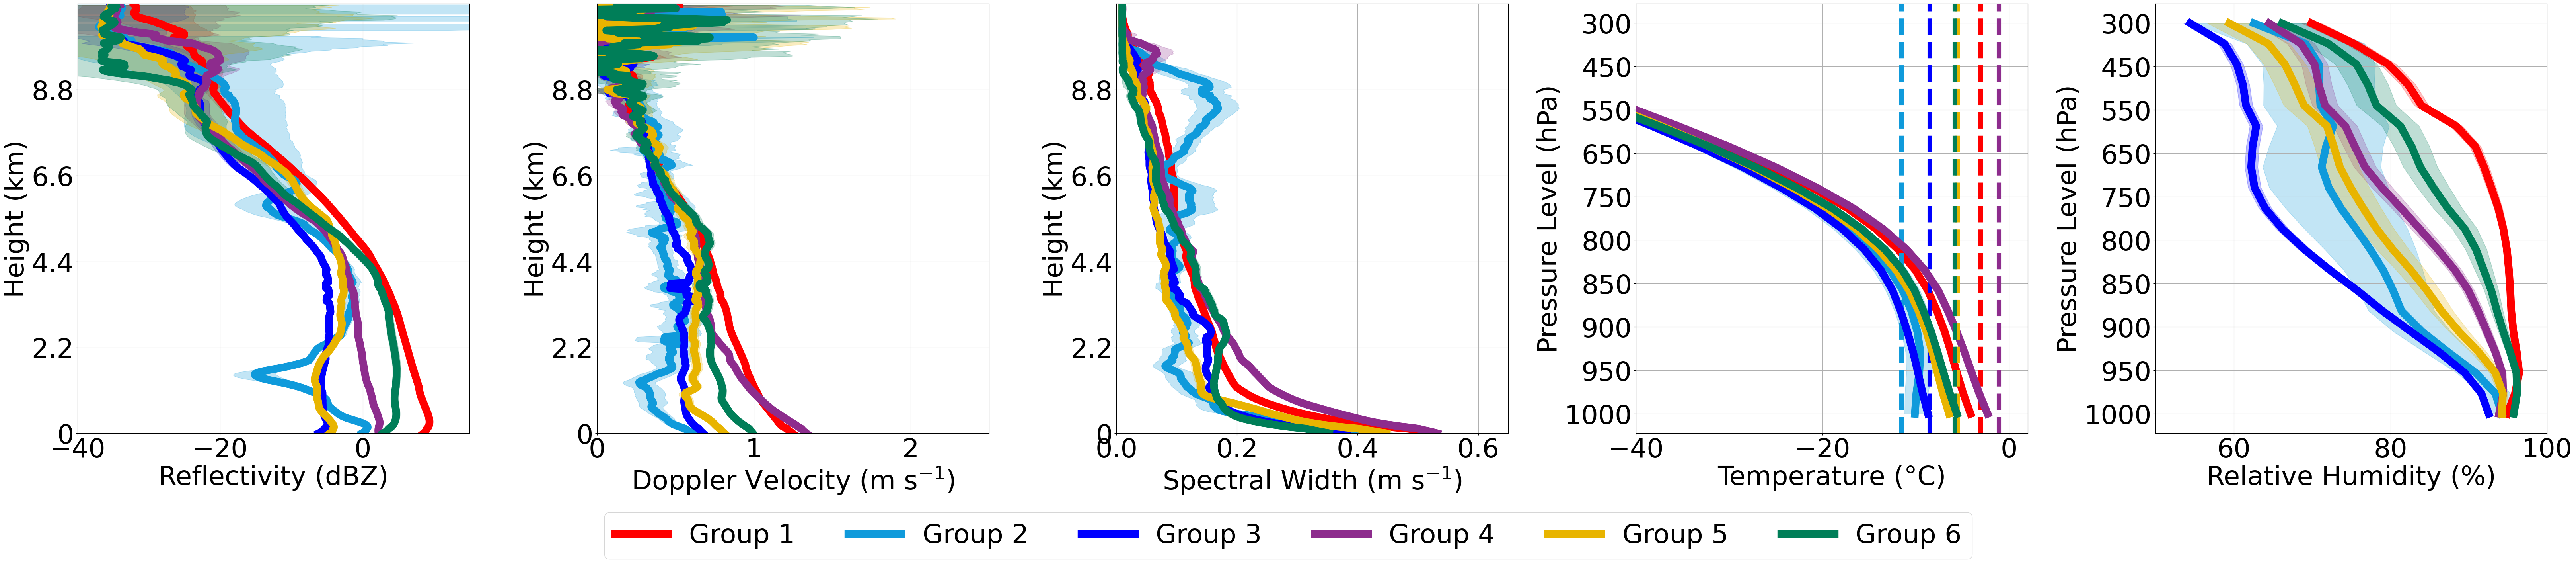

Reflectivity Column 0 17.08927876926103
Reflectivity Column 1 10.325414598986436
Reflectivity Column 2 1.7284081606114678
Reflectivity Column 3 10.79714529687071
Reflectivity Column 4 2.1986697093999976
Reflectivity Column 5 14.003655018564773
DV Column 0 1.525128693327879
DV Column 1 0.7716223223529411
DV Column 2 1.0134140386159534
DV Column 3 1.814953410831214
DV Column 4 1.4387917665625005
DV Column 5 0.9212673643553467
SW Column 0 0.6413149524048802
SW Column 1 0.5053523833823529
SW Column 2 0.3901882755805308
SW Column 3 0.5720410109456029
SW Column 4 0.4405589231249998
SW Column 5 0.3804417322327046
T Column 0 -36.137669810875416
mean T 267.4956766076555
T Column 1 -39.563197839117656
mean T 263.15163398692806
T Column 2 -39.7505338706908
mean T 266.1719164118246
T Column 3 -35.82766665032542
mean T 270.9209427780601
T Column 4 -39.02878458072914
mean T 264.8299768518518
T Column 5 -38.90496218667735
mean T 266.9653971581644
RH Column 0 72.95751942082074
RH Column 1 66.514373378

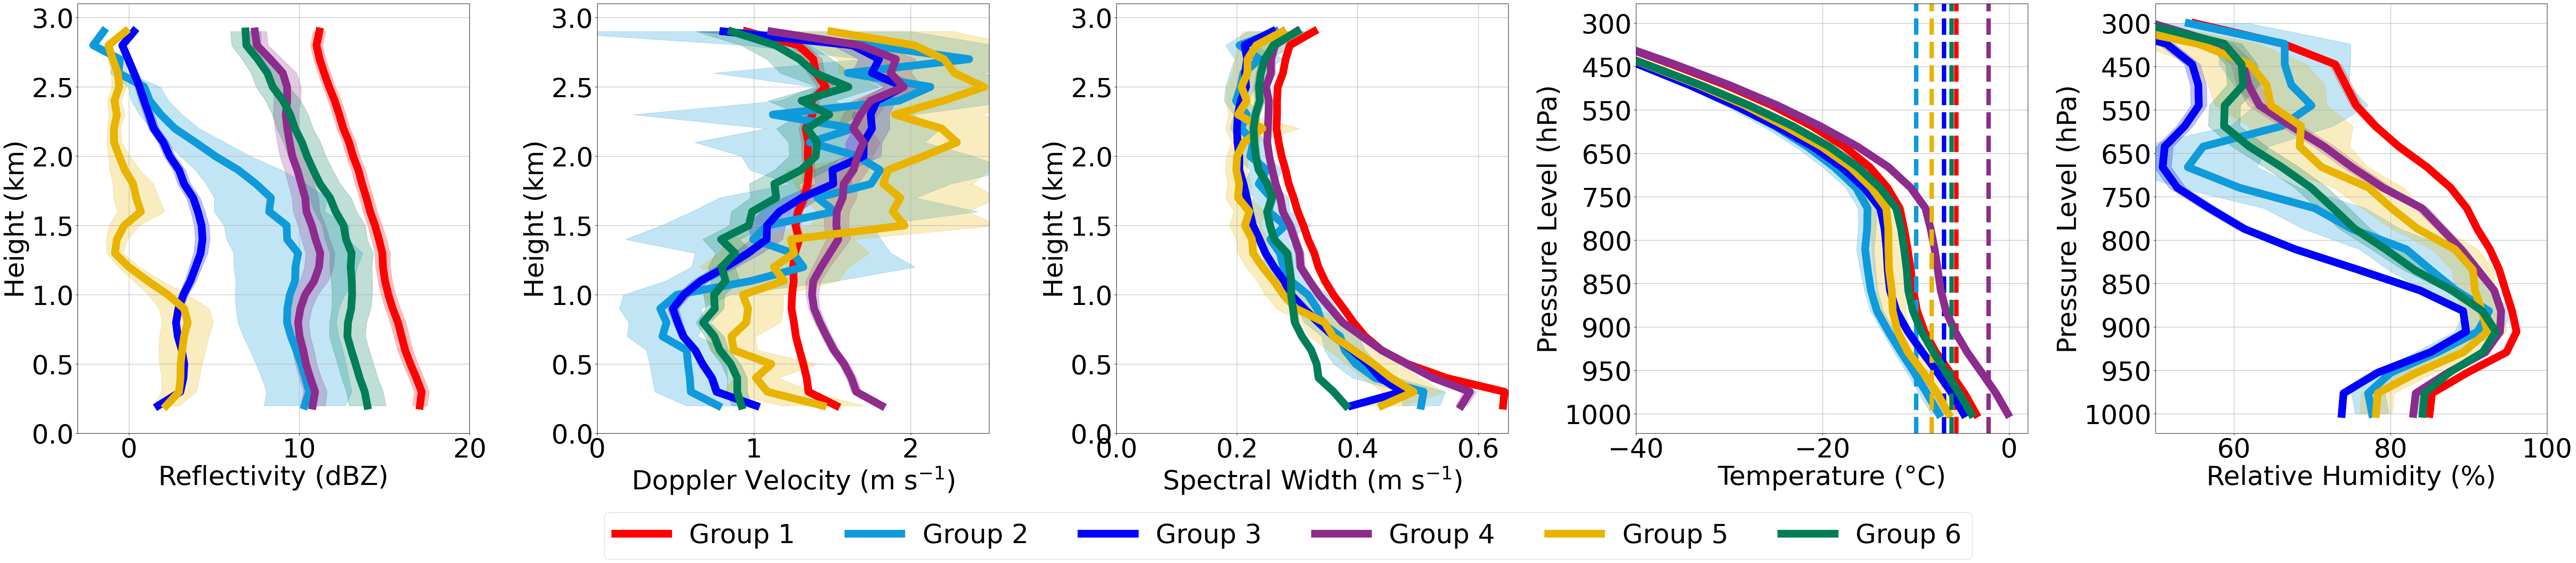

In [53]:
### CALCULATE LONG-TERM AVERAGES

# plot_group_stats: Helper function for calculating average climate variable vertical profiles (and their 95\% CIs)
def plot_group_stats(path, height, extent, roll_val, title, mins, maxs, use_special):
    df = pd.read_csv(path)
    df['Pressure'] = df['Pressure'].replace(1000, np.nan)
    df['Relative Humidity'] = df['Relative Humidity'].replace(50, np.nan)
    df['Temperature'] = df['Temperature'].replace(300, np.nan)

    def convert_dbz_z(array, reverse=False):
        if reverse:
            return 10 * np.log10(array)
        else:
            return 10 ** (array / 10)

    def string_to_list(s, height):
        elements = s.strip('[]').replace('\n', ' ').split()
        vals = [float(elem) if elem != 'nan' else np.nan for elem in elements]
        while len(vals) < height:
            vals.append(np.nan)
        return vals
    
    plt.rcParams.update({'font.size': 48})
    fig, axes = plt.subplots(figsize=(66, 15), nrows=1, ncols=5)
    data_columns = ['Reflectivity Column', 'DV Column', 'SW Column', 'T Column', 'RH Column']
    x_labels = ["Reflectivity (dBZ)", "Doppler Velocity (m s$^{-1}$)", "Spectral Width (m s$^{-1}$)", "Temperature (°C)", "Relative Humidity (%)"]
    handles, labels = [], []

    for i, (data_column, x_label) in enumerate(zip(data_columns, x_labels)):
        for group in np.arange(6):
            group_df = df[df['Group'] == group+1]
            mean_t = group_df['Temperature'].mean()
            current_height = 20 if data_column in ['T Column', 'RH Column'] else height
            inter = np.array([string_to_list(row, current_height) for row in group_df[data_column]])
        
            if data_column in ['T Column']:
                inter = inter - 273.15

            if data_column in ['T Column', 'RH Column']:
                inter[inter > 500] = np.nan
            elif data_column in ['DV Column'] and height > 100:
                inter[inter > 3] = np.nan
                inter[inter < -3] = np.nan 
                inter = -inter
            else:
                inter[inter > 100] = np.nan

            if data_column in ['Reflectivity Column']:
                inter = convert_dbz_z(inter)
                array_2d = np.nanmean(inter, axis=0)
                std_dev = np.nanstd(inter, axis=0)
                n = np.sum(~np.isnan(inter), axis=0)
                std_dev = 2* (convert_dbz_z(std_dev, True) / np.sqrt(n))
                array_2d = convert_dbz_z(array_2d, True)
            else:
                array_2d = np.nanmean(inter, axis=0)
                std_dev = np.nanstd(inter, axis=0)
                n = np.sum(~np.isnan(inter), axis=0)
                std_dev = 2*(std_dev / np.sqrt(n))

            rolling_mean = pd.Series(array_2d).rolling(window=roll_val, min_periods=1).mean()
            rolling_std = pd.Series(std_dev).rolling(window=roll_val, min_periods=1).mean()
            axes[i].plot(rolling_mean, np.arange(current_height), color=palette[group], linewidth=14, label='Group ' + str(group+1))
            axes[i].fill_betweenx(np.arange(current_height), rolling_mean-rolling_std, rolling_mean+rolling_std, color=palette[group], alpha=0.25)
            axes[i].set_xlim((mins[i], maxs[i]))
            handle, label = axes[i].get_legend_handles_labels()
            handles.extend(handle)
            labels.extend(label)

            if data_column in ['T Column']:
                print("mean T", mean_t)
                axes[i].axvline(mean_t - 273.15, linestyle='--', linewidth=8, color=palette[group])

        if i > 2:
            pressure_levels = [300, 450, 550, 650, 750, 800, 850, 900, 950, 1000]
            axes[i].set_yticks(np.linspace(0, 19, len(pressure_levels)))
            axes[i].set_yticklabels(pressure_levels)
            axes[i].invert_yaxis()
        else:
            axes[i].set_ylim((0, current_height))
            current_ticks = axes[i].get_yticks()
            scale_ratio = extent / current_height
            scaled_ticks = current_ticks * scale_ratio
            axes[i].set_yticklabels(scaled_ticks.astype(int)/1000)
        axes[i].set_xlabel(x_label)        

    for i,ax in enumerate(axes):
        if i > 2:
            ax.set_ylabel("Pressure Level (hPa)")
        else:
            ax.set_ylabel("Height (km)")
            if use_special:
                ax.set_yticks(range(0, 370, 74), [0, 2.2, 4.4, 6.6, 8.8])
        ax.grid()

    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    unique_handles, unique_labels = zip(*unique)
    fig.legend(unique_handles, unique_labels, loc='lower center', ncol=len(unique_labels), bbox_to_anchor=(0.5, -0.05))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

fin_mins = [-40, 0, 0, -40, 50]
fin_maxs = [15, 2.5, 0.65, 2, 100]
mrr_mins = [-3, 0, 0, -40, 50]
mrr_maxs = [20, 2.5, 0.65, 2, 100]

plot_group_stats('/Users/fraserking/Development/pca/data/pca_group_analysis/group_stats_finland.csv', 370, 11000, 5, 'Profile Groups - FIN (fmcw-94)', fin_mins, fin_maxs, True)
plot_group_stats('/Users/fraserking/Development/pca/data/pca_group_analysis/group_stats_marquette.csv', 31, 3100, 1, 'Profile Groups - MQT (MRR)', mrr_mins, mrr_maxs, False)

In [ ]:
print("All done!")